In [1]:
import os
# Set environment variable
if "ACCEPT_TC" not in os.environ:
    os.environ["ACCEPT_TC"] = "tôi đồng ý"
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from vnstock3 import Vnstock
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
import F  # Assuming 'F' is a module you've created
import matplotlib.pyplot as plt

In [2]:
# Get current date
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")

# Fetch VN30 and VNI stock data
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2020-08-01', end=current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2020-08-01', end=current_date, to_df=True)

2024-07-06 14:33:35,008 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


2024-07-06 14:33:36,287 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [3]:
# Function to process data
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)
    data['rsi'] = ta.rsi(data['close'], length=14)
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

# Process the VN30 and VNI data
data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

# Function to create GRU model
def create_gru_model(input_shape):
    model = Sequential([
        GRU(100, return_sequences=True, input_shape=input_shape),
        GRU(100),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Function to prepare data for GRU model
def prepare_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Function to train GRU model
def model_GRU(data, time_steps=60, epochs=50, batch_size=64):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_features)
    
    X, y = prepare_data(data_scaled, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    model = create_gru_model((time_steps, data_features.shape[1]))
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, scaler, time_steps

# Function to get prediction from GRU model
def output_GRU(model, scaler, data, time_steps=60):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    data_scaled = scaler.transform(data_features)
    
    X = np.array([data_scaled[-time_steps:]])
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    predicted_price = model.predict(X)
    predicted_price = scaler.inverse_transform(np.concatenate([predicted_price, np.zeros((predicted_price.shape[0], data_features.shape[1]-1))], axis=1))[:, 0]
    
    return predicted_price[0]

# Backtesting function
def test(data, k):
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Initialize model
    model_gru, scaler_gru, time_steps_gru = model_GRU(data, time_steps=k)
    
    for i in range(k, len(data)):
        historical_data = data.iloc[i-k:i]
        
        gru_pred = output_GRU(model_gru, scaler_gru, historical_data, time_steps_gru)
        
        predictions = gru_pred - data.iloc[i-1]['close']
        
        data_output.loc[i, 'position'] = 1 if predictions > 2 else (-1 if predictions < -2 else 0)
    
    data_output.dropna(inplace=True)
    return data_output

# Plotting function for PNL with annotation
def plot_pnl_with_annotation(data, symbol):
    backtesting = F.BacktestInformation(data['time'], data['position'], data['close'])
    pnl_data = backtesting.Plot_PNL(plot=False)
    
    # Plot PNL
    plt.figure(figsize=(15, 6))
    pnl_data['total_gain'].plot(label='Total Gain')
    pnl_data['total_gain_after_fee'].plot(label='Total Gain After Fee')

    plt.title(f'PNL for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('PNL')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Stock: {symbol}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    plt.show()

Epoch 1/50
14/14 [==============================] - 7s 132ms/step - loss: 0.1356
Epoch 2/50
14/14 [==============================] - 2s 130ms/step - loss: 0.0384
Epoch 3/50
14/14 [==============================] - 2s 131ms/step - loss: 0.0220
Epoch 4/50
14/14 [==============================] - 2s 136ms/step - loss: 0.0174
Epoch 5/50
14/14 [==============================] - 2s 134ms/step - loss: 0.0155
Epoch 6/50
14/14 [==============================] - 2s 143ms/step - loss: 0.0149
Epoch 7/50
14/14 [==============================] - 2s 143ms/step - loss: 0.0143
Epoch 8/50
14/14 [==============================] - 2s 134ms/step - loss: 0.0135
Epoch 9/50
14/14 [==============================] - 2s 136ms/step - loss: 0.0136
Epoch 10/50
14/14 [==============================] - 2s 130ms/step - loss: 0.0133
Epoch 11/50
14/14 [==============================] - 2s 129ms/step - loss: 0.0134
Epoch 12/50
14/14 [==============================] - 2s 131ms/step - loss: 0.0138
Epoch 13/50
14/14 [======

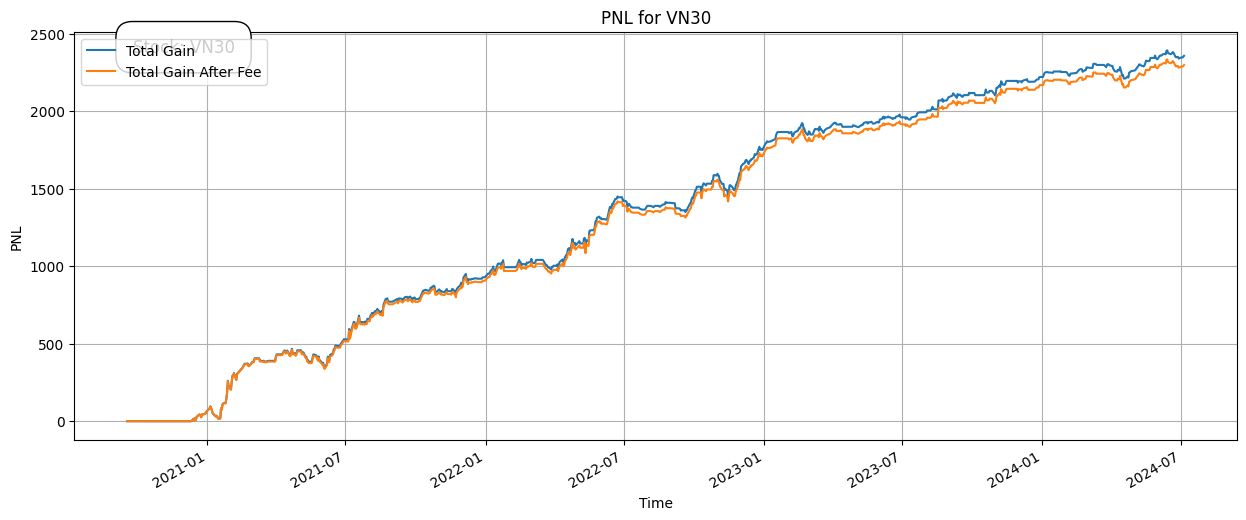

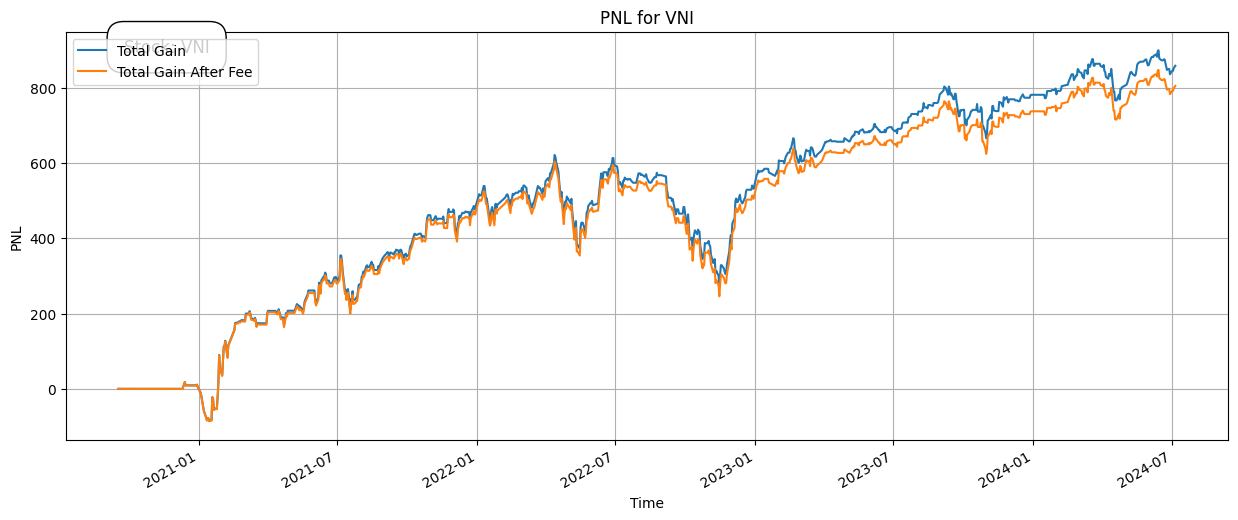

Backtesting Results for VN30
Margin: 66.65357722213848
MDD: (122.26025316455764, 0.07864469291874877)

   Total trading quantity: 138
         Profit per trade: 17.073405797101437
             Total Profit: 2356.1
         Profit after fee: 2296.7
 Trading quantity per day: 0.14556962025316456
 Profit per day after fee: 2.4226793248945144
                   Return: 0.38878079547797506
          Profit per year: 604.3947368421052
                  HitRate: 0.6521739130434783
          HitRate per day: 0.41288278775079196


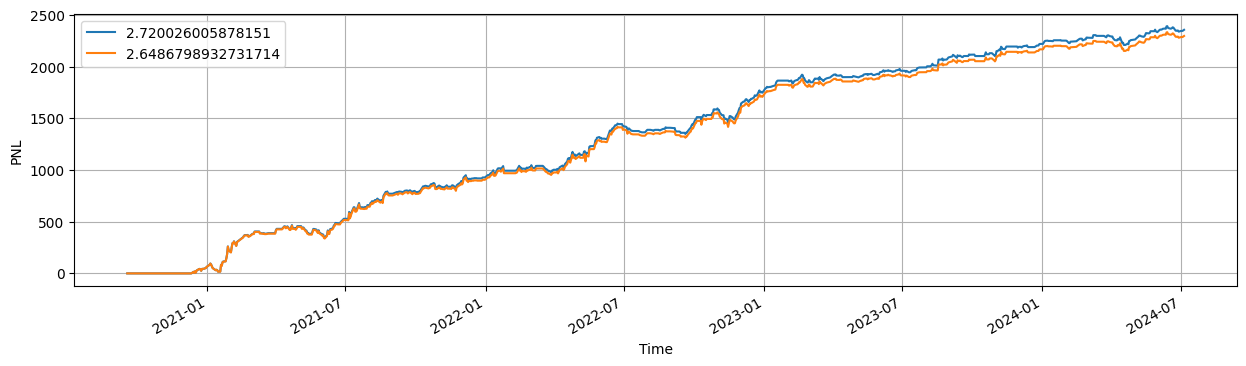

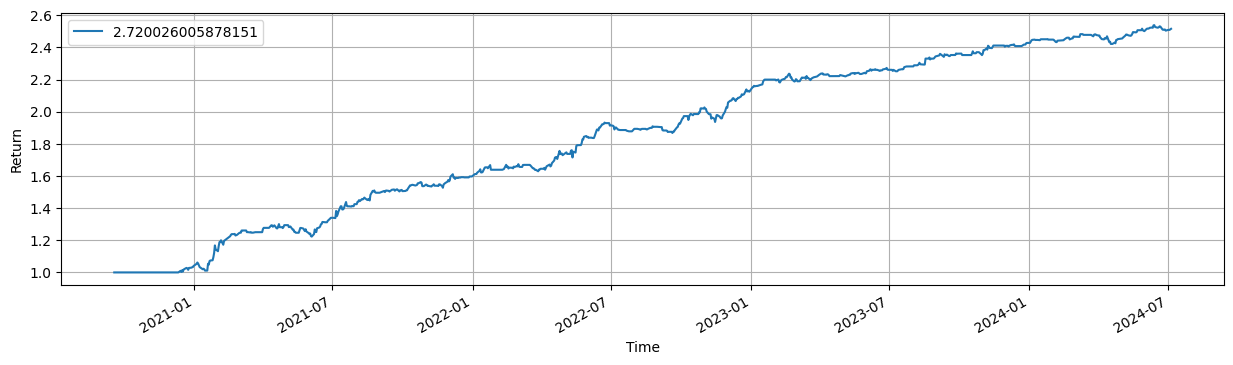

Backtesting Results for VNI
Margin: 27.716133328394392
MDD: (186.54909282700453, 0.12204157665465405)

   Total trading quantity: 125
         Profit per trade: 6.864079999999994
             Total Profit: 858.0
         Profit after fee: 804.6
 Trading quantity per day: 0.13185654008438819
 Profit per day after fee: 0.8487341772151898
                   Return: 0.1385195588721898
          Profit per year: 211.73684210526318
                  HitRate: 0.632
          HitRate per day: 0.38965153115100315


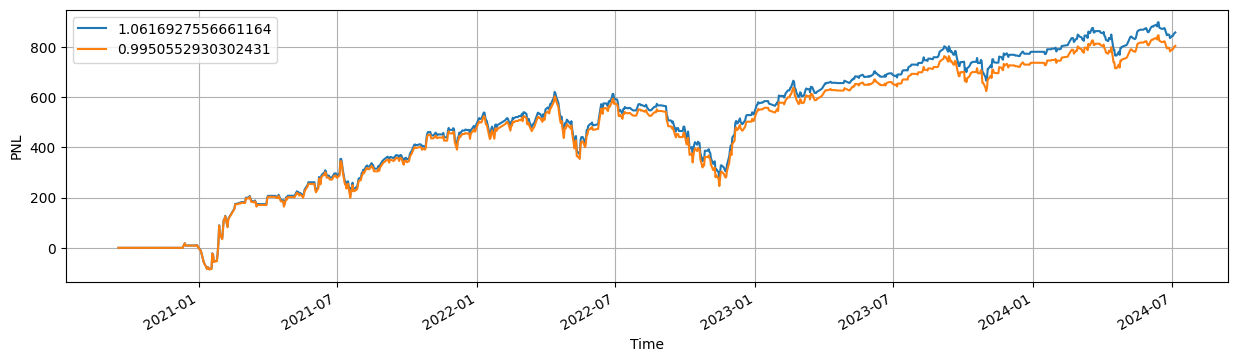

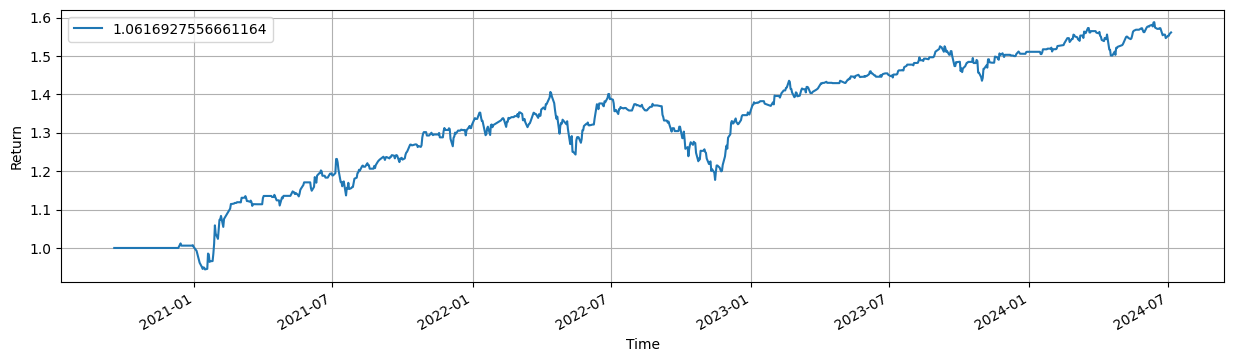

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-09-18,0.00,0.000000,0.000000,0,900.95,1.000000
2020-09-21,0.00,0.000000,0.000000,0,907.94,1.000000
2020-09-22,0.00,0.000000,0.000000,0,906.19,1.000000
2020-09-23,0.00,0.000000,0.000000,0,912.50,1.000000
2020-09-24,0.00,0.000000,0.000000,0,908.58,1.000000
...,...,...,...,...,...,...
2024-07-01,844.76,53.197046,791.562954,0,1254.56,1.552647
2024-07-02,844.76,53.411551,791.348449,1,1269.79,1.552647
2024-07-03,851.82,53.411551,798.408449,1,1276.85,1.557266


In [4]:
# Run the backtesting for VN30 and VNI
data_VNI_position = test(data_VNI, 60)
data_VN30_position = test(data_VN30, 60)

plot_pnl_with_annotation(data_VN30_position, 'VN30')
plot_pnl_with_annotation(data_VNI_position, 'VNI')

# Print backtesting results
backtesting_VN30 = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtesting_VNI = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])

print("Backtesting Results for VN30")
backtesting_VN30.Plot_PNL()

print("Backtesting Results for VNI")
backtesting_VNI.Plot_PNL()